<a href="https://colab.research.google.com/github/bwanatemba/Advanced-AI-Course-Codespaces/blob/main/LightGBM_(binary_classification%2C_early_stopping).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[LightGBM] [Info] Number of positive: 747, number of negative: 753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498000 -> initscore=-0.008000
[LightGBM] [Info] Start training from score -0.008000
Best iteration: 114
Accuracy: 0.912 | ROC-AUC: 0.968


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


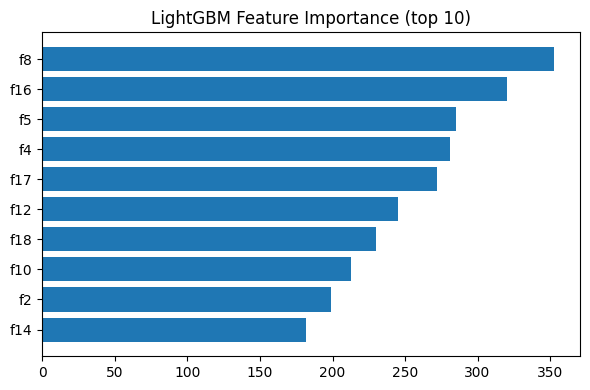

In [3]:
# If running in Colab, first run:
# !pip -q install lightgbm scikit-learn matplotlib

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier
from lightgbm import early_stopping

# 1) Dataset
X, y = make_classification(
    n_samples=2000, n_features=20, n_informative=8, n_redundant=4,
    n_clusters_per_class=2, flip_y=0.02, class_sep=1.5, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 2) LightGBM model with early stopping
lgbm = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 3) Train with validation and early stopping
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="logloss",
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

# 4) Evaluate
proba = lgbm.predict_proba(X_valid)[:, 1]
pred  = (proba >= 0.5).astype(int)
acc   = accuracy_score(y_valid, pred)
auc   = roc_auc_score(y_valid, proba)

print(f"Best iteration: {lgbm.best_iteration_}")
print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# 5) Feature importance
imp = lgbm.feature_importances_
order = np.argsort(imp)[::-1][:10]
plt.figure(figsize=(6,4))
plt.barh(range(len(order)), imp[order][::-1])
plt.yticks(range(len(order)), [f"f{idx}" for idx in order][::-1])
plt.title("LightGBM Feature Importance (top 10)")
plt.tight_layout()
plt.show()